# Cloud Filters

In this example we will create a percentile based filter over an image collection. We will compare the result with GEE filters (`ee.Algorithms.Landsat.Fmask.matchClouds`, `ee.Algorithms.Landsat.SimpleCloudScore`, `QABand` and `CFMask` from the `LANDSAT/LC8_SR` collection).


## Model Description

Let $\{X_t\}_1^T$ be our set of multiband images ($X_t \in \mathbb{R}(p\times B)$ where $p \equiv \text{number of pixels} $ and $B \equiv \text{number of bands}$). We will compute the 50 percentile (median) multiband image $X_{per} \in \mathbb{R}(p\times B)$. The aggregation (*reduce*) dimension will be the time $t$. We will compute the mean absolute deviation from the $X_{perc}$ image:

$$
X_{dev} = \frac{1}{T}\sum_{t=1}^T |X_t-X_{per}|
$$

As it is defined, $X_{dev}$ image takes into account cloudy pixels. To mitigate this we filter values which are above/below two *filter_percentiles*, hence the deviation only takes into account non-extreme pixel values.

Given a new image $X^\star$ for each pixel we will compute the deviation:
$$
X_{diff} = \sqrt{\frac{1}{B}\sum_{b=1}^B\left(\frac{X^\star-X_{per}}{X_{dev}}\right)^2}
$$

$X_{diff}\in\mathbb{R}(p)$ hence, it can be used as a cloud mask when $X_{diff}$ pixel values which exceeds a predefined *threshold*. 

It's worth to notice that the above expression can be written in matrix notation for each multiband pixel:

$$
X_{diff}(p)^2 = \frac{1}{B}(X^\star(p)-X_{perc}(p))^t \cdot \left(\begin{array}{cc} 1/X_{dev}(p,1) & 0 &... & 0 \\ 0 & 1/X_{dev}(p,2) & 0 ... & 0 \\ \vdots & \vdots & \vdots & \vdots \\ 0 & ...& 0 & 1/X_{dev}(p,B) \end{array}\right) \cdot (X^\star(p)-X_{perc}(p))
$$

Where $X(p)$ is the multiband pixel $X(p)\in \mathbb{R}(B)$.

This dummy model has been implemented in `ee_ipl_uv.percentile_filter.PercentileFilter` class.


In [1]:
import ee
from ee_ipl_uv import percentile_filter
from ee_ipl_uv import predefined_cloud_algorithms

# Reload module in case we are modifying the module at the same time
reload(percentile_filter)
percentile = 50

# Initialize the Earth Engine object, using the authentication credentials.
ee.Initialize()

imageCollection = ee.ImageCollection('LANDSAT/LC8_L1T_TOA')

geom_valencia = ee.Geometry.Polygon([[-0.50262451171875,39.39269330108945],
 [-0.267791748046875,39.38526381099777],
 [-0.26092529296875,39.54005788576377],
 [-0.501251220703125,39.53793974517628],
 [-0.50262451171875,39.39269330108945]])

start = ee.Date('2015-04-29')
finish = ee.Date('2016-05-18')

filteredCollection = imageCollection.filterBounds(geom_valencia) \
   .filterDate(start, finish) \
   .sort("system:time_start")

def recortar (imagen):
    return imagen.clip(geom_valencia)

print("The number of images is:",filteredCollection.size().getInfo())

model = percentile_filter.PercentileFilter(threshold=4.2,filter_percentiles=[20,75])

# Train the model
model.train(filteredCollection)

('The number of images is:', 69)


We can access to `percentile_image` and `sd_from_percentile_image` in the `model` object. ($X_p$ and $X_{dev}$ on our model description)

In [2]:
# import ee.mapclient
# ee.mapclient.centerMap(-0.368, 39.4722, 11)

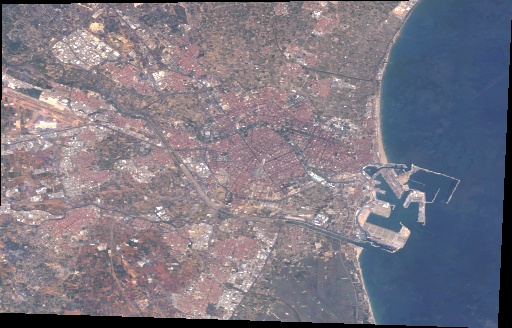

In [3]:
# ee.mapclient.addToMap(model.percentile_image, {'bands': ['B4_p50','B3_p50', 'B2_p50'],"max":.3})
from IPython.display import Image
from ee_ipl_uv import download

imagen_file = download.MaybeDownloadThumb(recortar(model.percentile_image),
                                          params={'bands': ",".join(['B4_p50','B3_p50', 'B2_p50']),"max":.3,
                                                  'format':'jpg'})

Image(imagen_file)

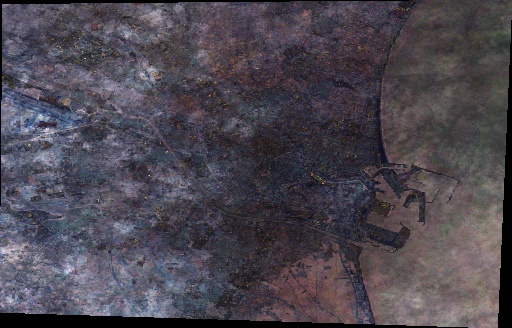

In [4]:
# ee.mapclient.addToMap(model.sd_from_percentile_image, {'bands': ['B4','B3', 'B2'],"max":.05})

imagen_file = download.MaybeDownloadThumb(recortar(model.sd_from_percentile_image),
                                          params={'bands': ",".join( ['B4','B3', 'B2']),"max":.05,
                                                  'format':'jpg'})
Image(imagen_file)

We can call `predict` to compute the cloud mask: 

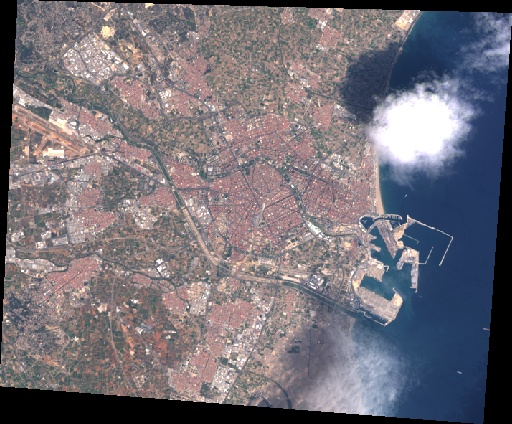

In [5]:
# Predict with the model
first_image = ee.Image(filteredCollection.first())

imagen_file = download.MaybeDownloadThumb(recortar(first_image),
                                          params={'bands': ",".join(['B4','B3', 'B2']),"max":.3,
                                                  'format':'jpg'})

Image(imagen_file)


# cloud_mask = cloud_mask.updateMask(cloud_mask) ## To mask (make invisible) no shadow pixels

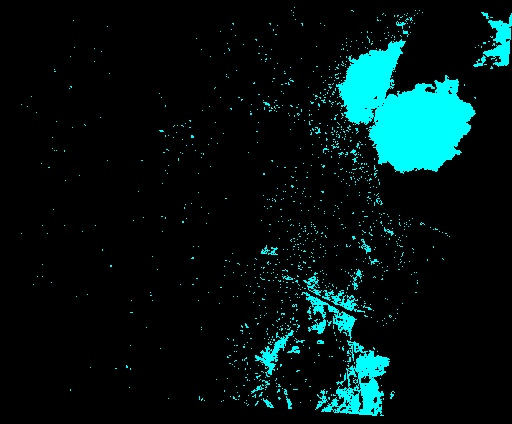

In [6]:
cloud_mask = model.predict(first_image)

# cloud_mask = model.predict(first_image,apply_threshold=False)
imagen_file = download.MaybeDownloadThumb(recortar(cloud_mask),
                                          params={'palette': ",".join(['000000','00FFFF']),
                                                  'format':'jpg'})

Image(imagen_file)
# ee.mapclient.addToMap(first_image, {'palette': ['000000','00FFFF'],'opacity':1,'max':4},"cloud mask")
# cloud_mask = cloud_mask.gt(4.2)
#ee.mapclient.addToMap(cloud_mask, {'palette': ['000000','00FFFF'],'opacity':1},"cloud mask")

## Compare mask with GEE models

### Compairson with `L8` *QA* Band

QABand description can be found [here](http://landsat.usgs.gov/qualityband.php). We will extract the mask with a custom function placed on `predefined_cloud_algorithms` module:

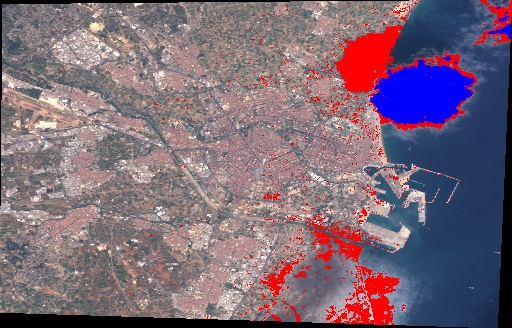

In [7]:
# ee.mapclient.addToMap(first_image, {'bands': ['B4','B3', 'B2'],"max":.3})

first_image_rgb = first_image.visualize(bands=['B4', 'B3', 'B2'], max= .3,opacity=.4)


qa_cloud_image = predefined_cloud_algorithms.QACloudMask(first_image,strict=True)
combined_masks = cloud_mask.uint16().leftShift(1).add(qa_cloud_image.uint16())
#minimo_y_max = cloud_mask.reduceRegion(ee.Reducer.minMax(),geom_valencia)
#print(minimo_y_max.getInfo())
combined_masks = combined_masks.updateMask(combined_masks)

combined_masks_vis = combined_masks.visualize(max=3,min=1,
                                              palette=['00FF00','FF0000','0000FF'])


mosaic = ee.ImageCollection([first_image_rgb, combined_masks_vis]).mosaic();
imagen_file = download.MaybeDownloadThumb(recortar(mosaic),
                                          params={'format':'jpg'})

Image(imagen_file)


# ee.mapclient.addToMap(combined_masks, {'max':3,'min':1,
#                                        'palette':['00FF00','FF0000','0000FF'],},"cloud masks")

We can use the not *strict* version (cloud confidence >33% instead of >67%)

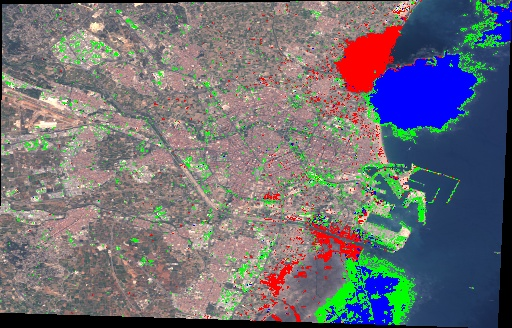

In [8]:
# ee.mapclient.addToMap(first_image, {'bands': ['B4','B3', 'B2'],"max":.3})

qa_cloud_image = predefined_cloud_algorithms.QACloudMask(first_image,strict=False)
combined_masks = cloud_mask.uint16().leftShift(1).add(qa_cloud_image.uint16())
#minimo_y_max = cloud_mask.reduceRegion(ee.Reducer.minMax(),geom_valencia)
#print(minimo_y_max.getInfo())
combined_masks = combined_masks.updateMask(combined_masks)

combined_masks_vis = combined_masks.visualize(max=3,min=1,
                                              palette=['00FF00','FF0000','0000FF'])


mosaic = ee.ImageCollection([first_image_rgb, combined_masks_vis]).mosaic();
imagen_file = download.MaybeDownloadThumb(recortar(mosaic),
                                          params={'format':'jpg'})

Image(imagen_file)


# ee.mapclient.addToMap(combined_masks, {'max':3,'min':1,
#                                       'palette':['00FF00','FF0000','0000FF'],
#                                       },"cloud masks")

## Compairson with `ee.Algorithms.FMask.matchClouds`

Fmask algorithm is implemented in EE platform. A version with natural default arguments have been implemented in `predefined_cloud_algorithms` module. It's important to notice that **this function does not work with clipped images**.

In [9]:
fmask_mask = predefined_cloud_algorithms.FMask(first_image)

# print(fmask_mask.getInfo())
# print fmask_output (yellow shadows green clouds)
#ee.mapclient.addToMap(fmask_mask, {
#  'palette':['ff0000','ffff00','00ff00'],'opacity':.5
#}, 'cloud_shadow_mask')

`FMask` returns an mask image where cloud pixels are 2, shadow pixels are 1 and the rest of the pixels are masked.

We will combine this mask with ours and see the resulted compairson mask.

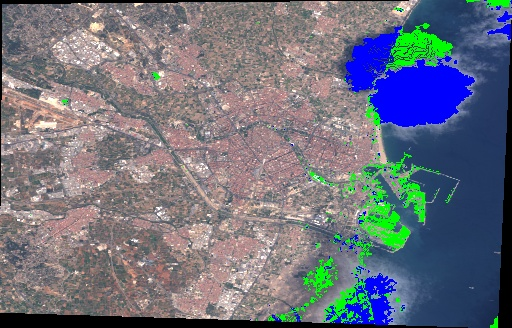

In [10]:
# ee.mapclient.addToMap(first_image, {'bands': ['B4','B3', 'B2'],"max":.3})
fmask_mask_clouds_and_shadows = fmask_mask.gt(0)
combined_masks = cloud_mask.uint16().leftShift(1).add(fmask_mask_clouds_and_shadows.uint16())
combined_masks = combined_masks.updateMask(combined_masks)

combined_masks_vis = combined_masks.visualize(max=3,min=1,
                                              palette=['00FF00','FF0000','0000FF'])


mosaic = ee.ImageCollection([first_image_rgb, combined_masks_vis]).mosaic();

imagen_file = download.MaybeDownloadThumb(recortar(mosaic),
                                          params={'format':'jpg'})

Image(imagen_file)


# ee.mapclient.addToMap(combined_masks, {
#   'max':3,'min':1,
#  'palette':['00FF00','FF0000','0000FF'],
# }, 'cloud_shadow_mask')

### Compairson shadow masks

With `cloud_and_shadow` option on `predict` function we can get an output similar to `FMask`: 1 for shadows and 2 for clouds. Using this we can easily compare cloud masks:

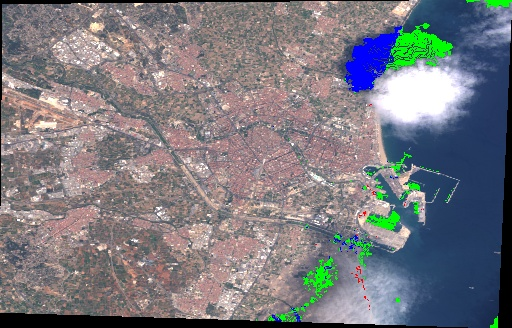

In [11]:
cloud_mask_shadows = model.predict(first_image,cloud_and_shadows=True)
percentile_mask_shadows = cloud_mask_shadows.eq(1)
fmask_shadows = fmask_mask.eq(1)


combined_masks = percentile_mask_shadows.uint16().leftShift(1).add(fmask_shadows.uint16())
combined_masks = combined_masks.updateMask(combined_masks)

combined_masks_vis = combined_masks.visualize(max=3,min=1,
                                              palette=['00FF00','FF0000','0000FF'])

mosaic = ee.ImageCollection([first_image_rgb, combined_masks_vis]).mosaic();

imagen_file = download.MaybeDownloadThumb(recortar(mosaic),
                                          params={'format':'jpg'})

Image(imagen_file)

# ee.mapclient.addToMap(first_image, {'bands': ['B4','B3', 'B2'],"max":.3})
# ee.mapclient.addToMap(combined_masks, {
#   'max':3,'min':1,
#  'palette':['00FF00','FF0000','0000FF'],
# }, 'cloud_shadow_mask')